# CESM-LE biomass shifts in the Southern Ocean

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the 1920s segment

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint']

ds_list = []
ds_1920s = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_monthly_1920s.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_1920s = xr.merge((ds_1920s, dsv))
    ds_list.append(ds_1920s)

diatC_zint
spC_zint
zooC_zint
CPU times: user 312 ms, sys: 20.7 ms, total: 332 ms
Wall time: 510 ms


### get the 1990s segment

In [3]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint']

ds_list = []
ds_1990s = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_monthly_1990s.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_1990s = xr.merge((ds_1990s, dsv))
    ds_list.append(ds_1990s)

diatC_zint
spC_zint
zooC_zint
CPU times: user 329 ms, sys: 19.7 ms, total: 348 ms
Wall time: 765 ms


### get the 2090s segment

In [4]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint']

ds_list = []
ds_2090s = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_monthly_2090s.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds_2090s = xr.merge((ds_2090s, dsv))
    ds_list.append(ds_2090s)

diatC_zint
spC_zint
zooC_zint
CPU times: user 351 ms, sys: 18 ms, total: 370 ms
Wall time: 519 ms


### calculate a couple extra fields

In [5]:
ds_1920s['mesozooC'] = ds_1920s.zooC_zint * (ds_1920s.diatC_zint/(ds_1920s.diatC_zint + ds_1920s.spC_zint))
ds_1920s['diat_frac'] = ds_1920s.diatC_zint/(ds_1920s.diatC_zint + ds_1920s.spC_zint)

In [6]:
ds_1990s['mesozooC'] = ds_1990s.zooC_zint * (ds_1990s.diatC_zint/(ds_1990s.diatC_zint + ds_1990s.spC_zint))
ds_1990s['diat_frac'] = ds_1990s.diatC_zint/(ds_1990s.diatC_zint + ds_1990s.spC_zint)

In [7]:
ds_2090s['mesozooC'] = ds_2090s.zooC_zint * (ds_2090s.diatC_zint/(ds_2090s.diatC_zint + ds_2090s.spC_zint))
ds_2090s['diat_frac'] = ds_2090s.diatC_zint/(ds_2090s.diatC_zint + ds_2090s.spC_zint)

In [8]:
## redefine variable list to include these
variables = ['diatC_zint','spC_zint','zooC_zint','mesozooC','diat_frac']

### get pop grid

In [9]:
grid = pop_tools.get_grid('POP_gx1v6')

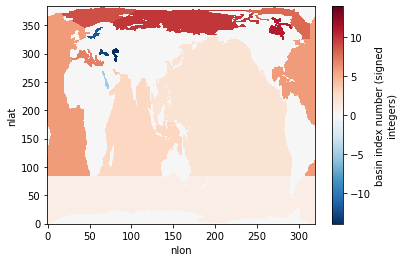

In [10]:
grid.REGION_MASK.plot()

In [11]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [12]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA

### mask out nans in ds

In [13]:
ds_1920s = ds_1920s.where(grid.REGION_MASK>0)
ds_1990s = ds_1990s.where(grid.REGION_MASK>0)
ds_2090s = ds_2090s.where(grid.REGION_MASK>0)

### make ensemble mean

In [14]:
ds_1920s_ens_mean = ds_1920s.mean(dim='member_id')
ds_1990s_ens_mean = ds_1990s.mean(dim='member_id')
ds_2090s_ens_mean = ds_2090s.mean(dim='member_id')

In [15]:
ds_1990s_ens_mean

<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 320, time: 120, z_t: 60)
Coordinates:
  * time        (time) object 1990-01-16 12:00:00 ... 1999-12-16 12:00:00
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz          (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    diatC_zint  (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    spC_zint    (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    zooC_zint   (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    mesozooC    (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    diat_frac   (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>

In [16]:
# diat_frac_shift = ds_2090s_ens_mean.diat_frac.mean(dim='time') - ds_1920s_ens_mean.diat_frac.mean(dim='time')

In [17]:
# diat_frac_shift.plot(vmin=-0.1,vmax=0.1,cmap='bwr')

### Make monthly climatology

In [18]:
ds_1920s_monthly_clim = ds_1920s_ens_mean.groupby('time.month').mean('time')
ds_1990s_monthly_clim = ds_1990s_ens_mean.groupby('time.month').mean('time')
ds_2090s_monthly_clim = ds_2090s_ens_mean.groupby('time.month').mean('time')

In [19]:
ds_1920s_monthly_clim

<xarray.Dataset>
Dimensions:     (month: 12, nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT         (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA       (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz          (month, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    diatC_zint  (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    spC_zint    (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    zooC_zint   (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    mesozooC    (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    diat_frac   (month, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>

### mask regions of the Southern Ocean: ACC and SIZ

In [20]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

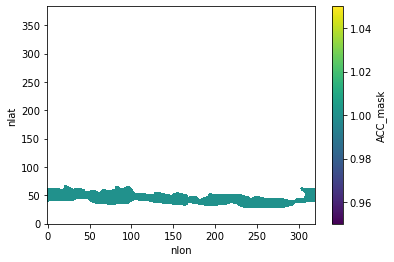

In [21]:
ds_masks.ACC_mask.plot()

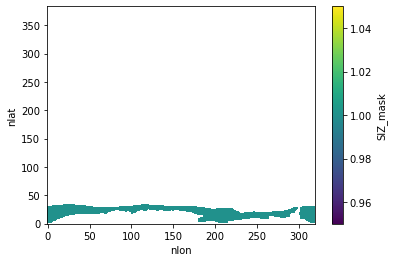

In [22]:
ds_masks.SIZ_mask.plot()

In [23]:
ts_1920s_ACC = xr.Dataset({v: ds_1920s_monthly_clim[v] for v in ['month']})
ts_1990s_ACC = xr.Dataset({v: ds_1990s_monthly_clim[v] for v in ['month']})
ts_2090s_ACC = xr.Dataset({v: ds_2090s_monthly_clim[v] for v in ['month']})


for var in variables:
    masked = ds_1920s_monthly_clim[var].where(ds_masks.ACC_mask==1.)
    ts_1920s_ACC[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_1990s_monthly_clim[var].where(ds_masks.ACC_mask==1.)
    ts_1990s_ACC[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_2090s_monthly_clim[var].where(ds_masks.ACC_mask==1.)
    ts_2090s_ACC[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_1920s_ACC = xr.concat([ts_1920s_ACC,ts_1920s_ACC.isel(month=slice(0,6))],dim='month')
ts_1990s_ACC = xr.concat([ts_1990s_ACC,ts_1990s_ACC.isel(month=slice(0,6))],dim='month')
ts_2090s_ACC = xr.concat([ts_2090s_ACC,ts_2090s_ACC.isel(month=slice(0,6))],dim='month')

In [24]:
ts_1920s_SIZ = xr.Dataset({v: ds_1920s_monthly_clim[v] for v in ['month']})
ts_1990s_SIZ = xr.Dataset({v: ds_1990s_monthly_clim[v] for v in ['month']})
ts_2090s_SIZ = xr.Dataset({v: ds_2090s_monthly_clim[v] for v in ['month']})


for var in variables:
    masked = ds_1920s_monthly_clim[var].where(ds_masks.SIZ_mask ==1.)
    ts_1920s_SIZ[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_1990s_monthly_clim[var].where(ds_masks.SIZ_mask ==1.)
    ts_1990s_SIZ[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
    masked = ds_2090s_monthly_clim[var].where(ds_masks.SIZ_mask ==1.)
    ts_2090s_SIZ[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()
    
ts_1920s_SIZ = xr.concat([ts_1920s_SIZ,ts_1920s_SIZ.isel(month=slice(0,6))],dim='month')
ts_1990s_SIZ = xr.concat([ts_1990s_SIZ,ts_1990s_SIZ.isel(month=slice(0,6))],dim='month')
ts_2090s_SIZ = xr.concat([ts_2090s_SIZ,ts_2090s_SIZ.isel(month=slice(0,6))],dim='month')

In [25]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
xvals = np.arange(1,19,1)

### Plot shifts in phytplankton biomass

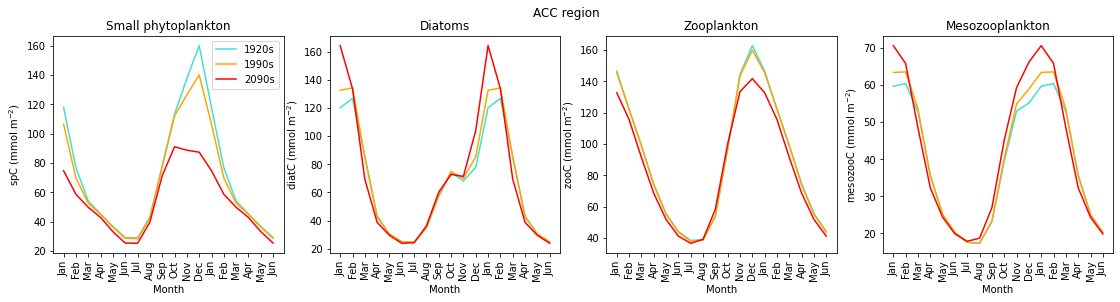

In [26]:
fig = plt.figure(figsize=(19,4))
fig.suptitle("ACC region")

########## small phytoplankton

ax1 = fig.add_subplot(1,4,1)
ax1.set_title('Small phytoplankton')
ax1.set_ylabel('spC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['spC_zint'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['spC_zint'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['spC_zint'], 
         color='red', label='2090s')

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')
########## diatoms

ax1 = fig.add_subplot(1,4,2)
ax1.set_title('Diatoms')
ax1.set_ylabel('diatC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['diatC_zint'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['diatC_zint'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['diatC_zint'], 
         color='red', label='2090s')

plt.xticks(xvals, xlabels, rotation='vertical')

########## zooC

ax1 = fig.add_subplot(1,4,3)
ax1.set_title('Zooplankton')
ax1.set_ylabel('zooC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['zooC_zint'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['zooC_zint'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['zooC_zint'], 
         color='red', label='2090s')

plt.xticks(xvals, xlabels, rotation='vertical')
########## mesozooC

ax1 = fig.add_subplot(1,4,4)
ax1.set_title('Mesozooplankton')
ax1.set_ylabel('mesozooC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['mesozooC'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['mesozooC'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['mesozooC'], 
         color='red', label='2090s');

plt.xticks(xvals, xlabels, rotation='vertical');

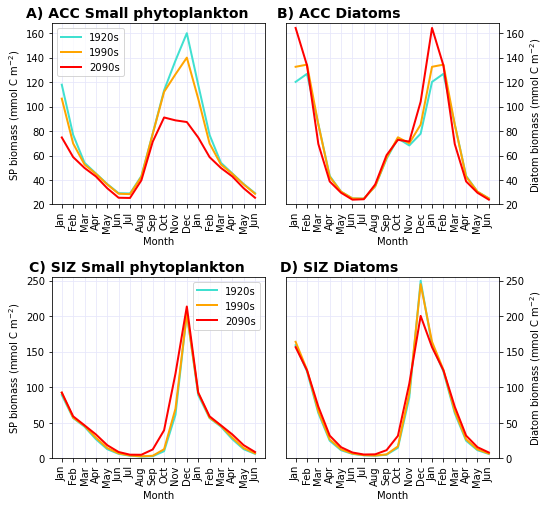

In [27]:
fig = plt.figure(figsize=(8,8))

######################################################## ACC
########## ACC small phytoplankton

ax1 = fig.add_subplot(2,2,1)
ax1.set_title('A) ACC Small phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('SP biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['spC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['spC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['spC_zint'], 
         color='red', label='2090s', lw=2)

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')
########## ACC diatoms

ax1 = fig.add_subplot(2,2,2)
ax1.set_title('B) ACC Diatoms',fontsize=14,fontweight='bold',x=0.25)
ax1.set_ylabel('Diatom biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['diatC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['diatC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['diatC_zint'], 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();
######################################################## SIZ
########## small phytoplankton

ax1 = fig.add_subplot(2,2,3)
ax1.set_title('C) SIZ Small phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('SP biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,255)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['spC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['spC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['spC_zint'], 
         color='red', label='2090s', lw=2)

ax1.legend()
plt.xticks(xvals, xlabels, rotation='vertical')
########## diatoms

ax1 = fig.add_subplot(2,2,4)
ax1.set_title('D) SIZ Diatoms',fontsize=14,fontweight='bold',x=0.25)
ax1.set_ylabel('Diatom biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,255)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['diatC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['diatC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['diatC_zint'], 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical')
plt.subplots_adjust(hspace=0.4,wspace=0.1)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();

fig.savefig('/glade/work/kristenk/figs/biomass_shifts_seas_cycle.png', bbox_inches='tight', dpi=300, format='png');


In [28]:
ts_1990s_SIZ_anoms = ts_1990s_SIZ - ts_1920s_SIZ
ts_2090s_SIZ_anoms = ts_2090s_SIZ - ts_1920s_SIZ

In [29]:
ts_1990s_ACC_anoms = ts_1990s_ACC - ts_1920s_ACC
ts_2090s_ACC_anoms = ts_2090s_ACC - ts_1920s_ACC

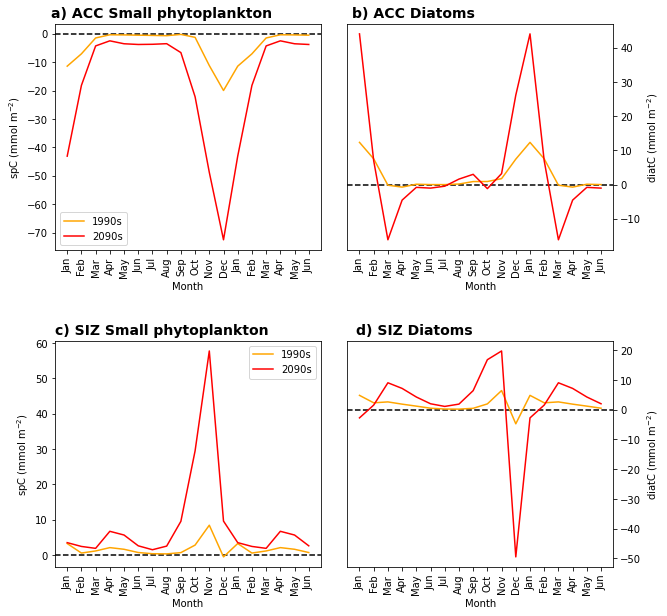

In [30]:
fig = plt.figure(figsize=(10,10))

######################################################## ACC
########## ACC small phytoplankton

ax1 = fig.add_subplot(2,2,1)
ax1.set_title('a) ACC Small phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('spC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(0,160)

plt.axhline(y=0, color='black', linestyle='--')
#plot 1990s anomalies
ax1.plot(xvals,ts_1990s_ACC_anoms['spC_zint'], 
         color='orange', label='1990s')

#plot 2090s anomalies
ax1.plot(xvals,ts_2090s_ACC_anoms['spC_zint'], 
         color='red', label='2090s')

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')
########## ACC diatoms

ax1 = fig.add_subplot(2,2,2)
ax1.set_title('b) ACC Diatoms',fontsize=14,fontweight='bold',x=0.25)
ax1.set_ylabel('diatC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(0,160)
plt.axhline(y=0, color='black', linestyle='--')
#plot 1990s anomalies
ax1.plot(xvals,ts_1990s_ACC_anoms['diatC_zint'], 
         color='orange', label='1990s')

#plot 2090s anomalies
ax1.plot(xvals,ts_2090s_ACC_anoms['diatC_zint'], 
         color='red', label='2090s')

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();
######################################################## SIZ
########## small phytoplankton

ax1 = fig.add_subplot(2,2,3)
ax1.set_title('c) SIZ Small phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('spC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(0,250)
plt.axhline(y=0, color='black', linestyle='--')
#plot 1990s anomalies
ax1.plot(xvals,ts_1990s_SIZ_anoms['spC_zint'], 
         color='orange', label='1990s')

#plot 2090s anomalies
ax1.plot(xvals,ts_2090s_SIZ_anoms['spC_zint'], 
         color='red', label='2090s')

ax1.legend()
plt.xticks(xvals, xlabels, rotation='vertical')
########## diatoms

ax1 = fig.add_subplot(2,2,4)
ax1.set_title('d) SIZ Diatoms',fontsize=14,fontweight='bold',x=0.25)
ax1.set_ylabel('diatC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(0,250)
plt.axhline(y=0, color='black', linestyle='--')
#plot 1990s anomalies
ax1.plot(xvals,ts_1990s_SIZ_anoms['diatC_zint'], 
         color='orange', label='1990s')

#plot 2090s anomalies
ax1.plot(xvals,ts_2090s_SIZ_anoms['diatC_zint'], 
         color='red', label='2090s')

plt.xticks(xvals, xlabels, rotation='vertical')
plt.subplots_adjust(hspace=0.4,wspace=0.1)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();

### plot only. 2090 anomalies and put sp and diat on the same plot

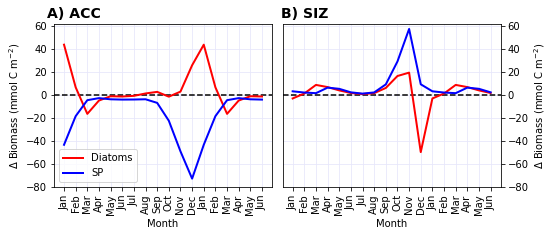

In [31]:
fig = plt.figure(figsize=(8,3))

######################################################## ACC
########## ACC small phytoplankton

ax1 = fig.add_subplot(1,2,1)
ax1.set_title('A) ACC ',fontsize=14,fontweight='bold',x=0.1)
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-80,62)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

plt.axhline(y=0, color='black', linestyle='--')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_ACC_anoms['diatC_zint'], 
         color='red', label='Diatoms',lw=2)

#plot 2090s anomalies sp
ax1.plot(xvals,ts_2090s_ACC_anoms['spC_zint'], 
         color='blue', label='SP',lw=2)

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')
########## ACC diatoms

ax1 = fig.add_subplot(1,2,2)
ax1.set_title('B) SIZ',fontsize=14,fontweight='bold',x=0.1)
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-80,62)
plt.axhline(y=0, color='black', linestyle='--')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_SIZ_anoms['diatC_zint'], 
         color='red', label='Diatoms',lw=2)

#plot 2090s anomalies sp
ax1.plot(xvals,ts_2090s_SIZ_anoms['spC_zint'], 
         color='blue', label='SP',lw=2)

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();

plt.subplots_adjust(wspace=0.05)

fig.savefig('/glade/work/kristenk/figs/change_biomass_shifts_seas_cycle.png', bbox_inches='tight', dpi=300, format='png');


### Combine absolute and anomaly figures

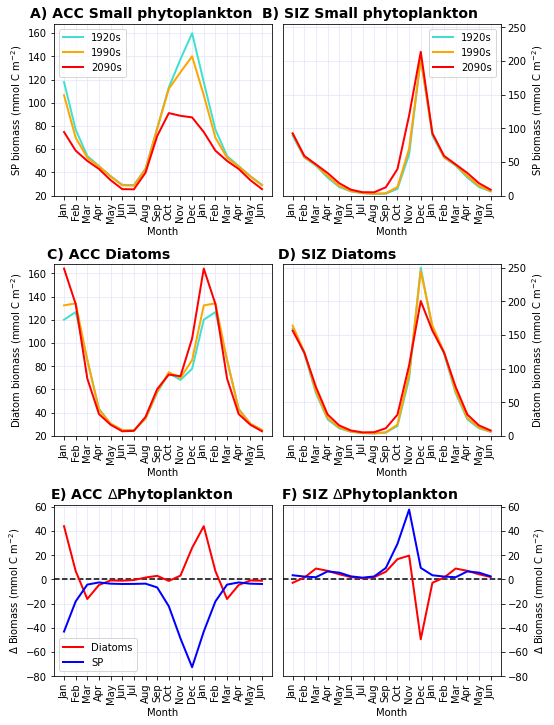

In [45]:
fig = plt.figure(figsize=(8,12))

######################################################## ACC
########## ACC small phytoplankton

ax1 = fig.add_subplot(3,2,1)
ax1.set_title('A) ACC Small phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('SP biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['spC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['spC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['spC_zint'], 
         color='red', label='2090s', lw=2)

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')

######################################################## SIZ
########## small phytoplankton

ax1 = fig.add_subplot(3,2,2)
ax1.set_title('B) SIZ Small phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('SP biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,255)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['spC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['spC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['spC_zint'], 
         color='red', label='2090s', lw=2)

ax1.legend()
plt.xticks(xvals, xlabels, rotation='vertical')


########## ACC diatoms

ax1 = fig.add_subplot(3,2,3)
ax1.set_title('C) ACC Diatoms',fontsize=14,fontweight='bold',x=0.25)
ax1.set_ylabel('Diatom biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(20,168)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['diatC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['diatC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['diatC_zint'], 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical');



########## SIZ diatoms

ax1 = fig.add_subplot(3,2,4)
ax1.set_title('D) SIZ Diatoms',fontsize=14,fontweight='bold',x=0.25)
ax1.set_ylabel('Diatom biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(0,255)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['diatC_zint'], 
         color='turquoise', label='1920s', lw=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['diatC_zint'], 
         color='orange', label='1990s', lw=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['diatC_zint'], 
         color='red', label='2090s', lw=2)

plt.xticks(xvals, xlabels, rotation='vertical')
plt.subplots_adjust(hspace=0.4,wspace=0.1)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();


########## delta ACC sp/diatoms
ax1 = fig.add_subplot(3,2,5)
ax1.set_title('E) ACC ${\Delta}$Phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-80,62)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

plt.axhline(y=0, color='black', linestyle='--')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_ACC_anoms['diatC_zint'], 
         color='red', label='Diatoms',lw=2)

#plot 2090s anomalies sp
ax1.plot(xvals,ts_2090s_ACC_anoms['spC_zint'], 
         color='blue', label='SP',lw=2)

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')



########## delta SIZ sp/diatoms

ax1 = fig.add_subplot(3,2,6)
ax1.set_title('F) SIZ ${\Delta}$Phytoplankton',fontsize=14,fontweight='bold',x=0.4)
ax1.set_ylabel('${\Delta}$ Biomass (mmol C m$^{-2}$)')
ax1.set_xlabel('Month')
ax1.set_ylim(-80,62)
plt.axhline(y=0, color='black', linestyle='--')
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')

#plot 2090s anomalies diat
ax1.plot(xvals,ts_2090s_SIZ_anoms['diatC_zint'], 
         color='red', label='Diatoms',lw=2)

#plot 2090s anomalies sp
ax1.plot(xvals,ts_2090s_SIZ_anoms['spC_zint'], 
         color='blue', label='SP',lw=2)

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right();

plt.subplots_adjust(wspace=0.05)
fig.savefig('/glade/work/kristenk/figs/biomass_shifts_seas_cycle_v2.png', bbox_inches='tight', dpi=300, format='png');


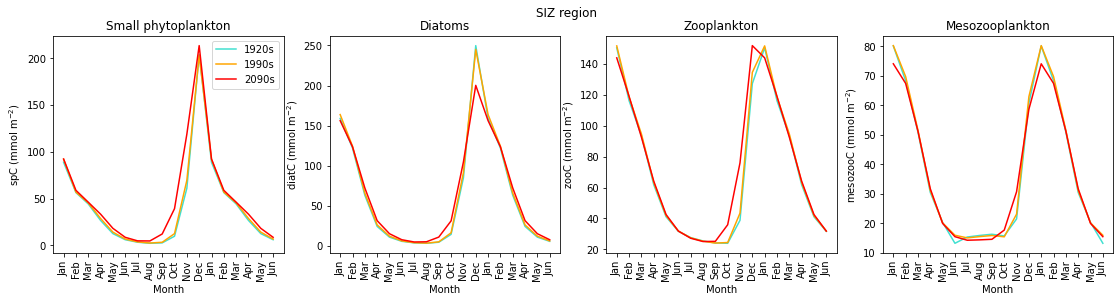

In [32]:
fig = plt.figure(figsize=(19,4))
fig.suptitle("SIZ region")

########## small phytoplankton

ax1 = fig.add_subplot(1,4,1)
ax1.set_title('Small phytoplankton')
ax1.set_ylabel('spC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['spC_zint'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['spC_zint'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['spC_zint'], 
         color='red', label='2090s')

ax1.legend()
plt.xticks(xvals, xlabels, rotation='vertical')
########## diatoms

ax1 = fig.add_subplot(1,4,2)
ax1.set_title('Diatoms')
ax1.set_ylabel('diatC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['diatC_zint'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['diatC_zint'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['diatC_zint'], 
         color='red', label='2090s')

plt.xticks(xvals, xlabels, rotation='vertical')

########## zooC

ax1 = fig.add_subplot(1,4,3)
ax1.set_title('Zooplankton')
ax1.set_ylabel('zooC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['zooC_zint'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['zooC_zint'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['zooC_zint'], 
         color='red', label='2090s')

plt.xticks(xvals, xlabels, rotation='vertical')
########## mesozooC

ax1 = fig.add_subplot(1,4,4)
ax1.set_title('Mesozooplankton')
ax1.set_ylabel('mesozooC (mmol m$^{-2}$)')
ax1.set_xlabel('Month')

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['mesozooC'], 
         color='turquoise', label='1920s')

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['mesozooC'], 
         color='orange', label='1990s')

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['mesozooC'], 
         color='red', label='2090s');

plt.xticks(xvals, xlabels, rotation='vertical');

In [33]:
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
xvals = np.arange(1,19,1)

In [34]:
# fig = plt.figure(figsize=(12,11))
# fig.suptitle("Region 1: north of diatom increase")

# ########## small phytoplankton

# ax1 = fig.add_subplot(2,2,1)
# ax1.set_title('a) Small phytoplankton',x=0.3,y=1,fontsize=12,weight='bold')
# ax1.set_ylabel('spC (mmol m$^{-2}$)')

# ax1.fill_between(xvals, 0, ts_1920s_region1['spC_zint'], color='turquoise', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_1990s_region1['spC_zint'], color='purple', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_2090s_region1['spC_zint'], color='red', alpha=0.4)


# #plot 1920s
# ax1.plot(xvals,ts_1920s_region1['spC_zint'], 
#          color='turquoise', label='1920s',linewidth=2)

# #plot 1990s
# ax1.plot(xvals,ts_1990s_region1['spC_zint'], 
#          color='purple', label='1990s',linewidth=2)

# #plot 2090s
# ax1.plot(xvals,ts_2090s_region1['spC_zint'], 
#          color='red', label='2090s',linewidth=2)

# ax1.legend()

# plt.xticks(xvals, xlabels, rotation='vertical')
# ########## diatoms

# ax1 = fig.add_subplot(2,2,2)
# ax1.set_title('b) Diatoms',x=0.2,y=1,fontsize=12,weight='bold')
# ax1.set_ylabel('diatC (mmol m$^{-2}$)')

# ax1.fill_between(xvals, 0, ts_1920s_region1['diatC_zint'], color='turquoise', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_1990s_region1['diatC_zint'], color='purple', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_2090s_region1['diatC_zint'], color='red', alpha=0.4)

# #plot 1920s
# ax1.plot(xvals,ts_1920s_region1['diatC_zint'], 
#          color='turquoise', label='1920s',linewidth=2)


# #plot 1990s
# ax1.plot(xvals,ts_1990s_region1['diatC_zint'], 
#          color='purple', label='1990s',linewidth=2)

# #plot 2090s
# ax1.plot(xvals,ts_2090s_region1['diatC_zint'], 
#          color='red', label='2090s',linewidth=2)

# plt.xticks(xvals, xlabels, rotation='vertical')

# ########## zooC

# ax1 = fig.add_subplot(2,2,3)
# ax1.set_title('c) Zooplankton',x=0.25,y=1,fontsize=12,weight='bold')
# ax1.set_ylabel('zooC (mmol m$^{-2}$)')

# ax1.fill_between(xvals, 0, ts_1920s_region1['zooC_zint'], color='turquoise', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_1990s_region1['zooC_zint'], color='purple', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_2090s_region1['zooC_zint'], color='red', alpha=0.4)

# #plot 1920s
# ax1.plot(xvals,ts_1920s_region1['zooC_zint'], 
#          color='turquoise', label='1920s',linewidth=2)

# #plot 1990s
# ax1.plot(xvals,ts_1990s_region1['zooC_zint'], 
#          color='purple', label='1990s',linewidth=2)

# #plot 2090s
# ax1.plot(xvals,ts_2090s_region1['zooC_zint'], 
#          color='red', label='2090s',linewidth=2)

# plt.xticks(xvals, xlabels, rotation='vertical')
# ########## mesozooC

# ax1 = fig.add_subplot(2,2,4)
# ax1.set_title('d) Mesozooplankton',x=0.325,y=1,fontsize=12,weight='bold')
# ax1.set_ylabel('mesozooC (mmol m$^{-2}$)')

# ax1.fill_between(xvals, 0, ts_1920s_region1['mesozooC'], color='turquoise', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_1990s_region1['mesozooC'], color='purple', alpha=0.4)
# ax1.fill_between(xvals, 0, ts_2090s_region1['mesozooC'], color='red', alpha=0.4)

# #plot 1920s
# ax1.plot(xvals,ts_1920s_region1['mesozooC'], 
#          color='turquoise', label='1920s',linewidth=2)

# #plot 1990s
# ax1.plot(xvals,ts_1990s_region1['mesozooC'], 
#          color='purple', label='1990s',linewidth=2)

# #plot 2090s
# ax1.plot(xvals,ts_2090s_region1['mesozooC'], 
#          color='red', label='2090s',linewidth=2);

# plt.xticks(xvals, xlabels, rotation='vertical');

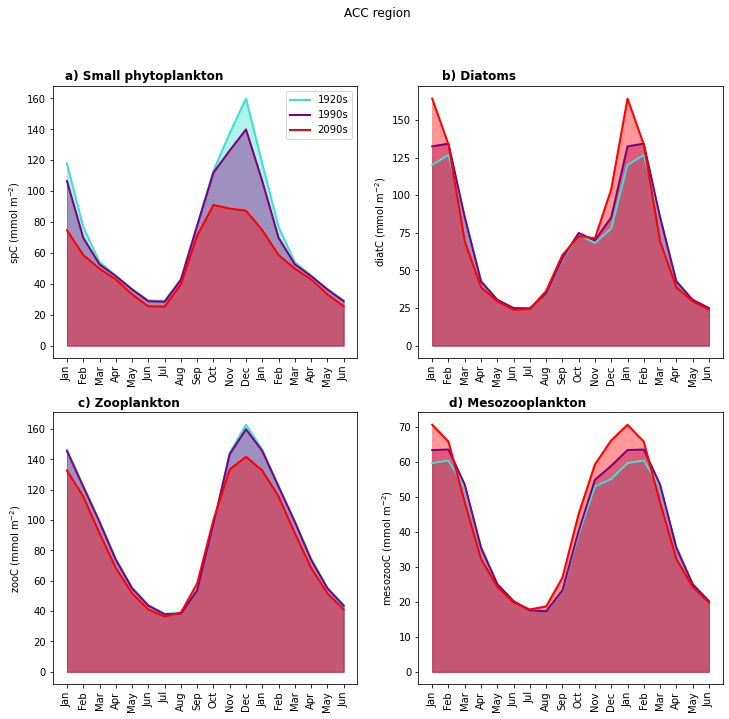

In [35]:
fig = plt.figure(figsize=(12,11))
fig.suptitle("ACC region")

########## small phytoplankton

ax1 = fig.add_subplot(2,2,1)
ax1.set_title('a) Small phytoplankton',x=0.3,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('spC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_ACC['spC_zint'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_ACC['spC_zint'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_ACC['spC_zint'], color='red', alpha=0.4)


#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['spC_zint'], 
         color='turquoise', label='1920s',linewidth=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['spC_zint'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['spC_zint'], 
         color='red', label='2090s',linewidth=2)

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')
########## diatoms

ax1 = fig.add_subplot(2,2,2)
ax1.set_title('b) Diatoms',x=0.2,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('diatC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_ACC['diatC_zint'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_ACC['diatC_zint'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_ACC['diatC_zint'], color='red', alpha=0.4)

#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['diatC_zint'], 
         color='turquoise', label='1920s',linewidth=2)


#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['diatC_zint'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['diatC_zint'], 
         color='red', label='2090s',linewidth=2)

plt.xticks(xvals, xlabels, rotation='vertical')

########## zooC

ax1 = fig.add_subplot(2,2,3)
ax1.set_title('c) Zooplankton',x=0.25,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('zooC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_ACC['zooC_zint'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_ACC['zooC_zint'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_ACC['zooC_zint'], color='red', alpha=0.4)

#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['zooC_zint'], 
         color='turquoise', label='1920s',linewidth=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['zooC_zint'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['zooC_zint'], 
         color='red', label='2090s',linewidth=2)

plt.xticks(xvals, xlabels, rotation='vertical')
########## mesozooC

ax1 = fig.add_subplot(2,2,4)
ax1.set_title('d) Mesozooplankton',x=0.325,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('mesozooC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_ACC['mesozooC'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_ACC['mesozooC'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_ACC['mesozooC'], color='red', alpha=0.4)

#plot 1920s
ax1.plot(xvals,ts_1920s_ACC['mesozooC'], 
         color='turquoise', label='1920s',linewidth=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_ACC['mesozooC'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_ACC['mesozooC'], 
         color='red', label='2090s',linewidth=2);

plt.xticks(xvals, xlabels, rotation='vertical');

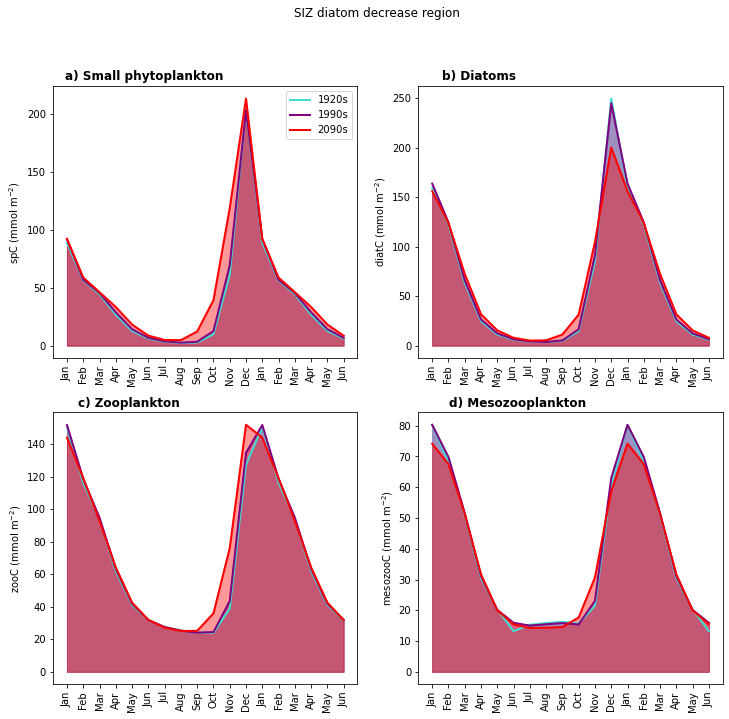

In [36]:
fig = plt.figure(figsize=(12,11))
fig.suptitle("SIZ diatom decrease region")

########## small phytoplankton

ax1 = fig.add_subplot(2,2,1)
ax1.set_title('a) Small phytoplankton',x=0.3,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('spC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_SIZ['spC_zint'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_SIZ['spC_zint'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_SIZ['spC_zint'], color='red', alpha=0.4)


#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['spC_zint'], 
         color='turquoise', label='1920s',linewidth=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['spC_zint'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['spC_zint'], 
         color='red', label='2090s',linewidth=2)

ax1.legend()

plt.xticks(xvals, xlabels, rotation='vertical')
########## diatoms

ax1 = fig.add_subplot(2,2,2)
ax1.set_title('b) Diatoms',x=0.2,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('diatC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_SIZ['diatC_zint'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_SIZ['diatC_zint'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_SIZ['diatC_zint'], color='red', alpha=0.4)

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['diatC_zint'], 
         color='turquoise', label='1920s',linewidth=2)


#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['diatC_zint'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['diatC_zint'], 
         color='red', label='2090s',linewidth=2)

plt.xticks(xvals, xlabels, rotation='vertical')

########## zooC

ax1 = fig.add_subplot(2,2,3)
ax1.set_title('c) Zooplankton',x=0.25,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('zooC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_SIZ['zooC_zint'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_SIZ['zooC_zint'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_SIZ['zooC_zint'], color='red', alpha=0.4)

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['zooC_zint'], 
         color='turquoise', label='1920s',linewidth=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['zooC_zint'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['zooC_zint'], 
         color='red', label='2090s',linewidth=2)

plt.xticks(xvals, xlabels, rotation='vertical')
########## mesozooC

ax1 = fig.add_subplot(2,2,4)
ax1.set_title('d) Mesozooplankton',x=0.325,y=1,fontsize=12,weight='bold')
ax1.set_ylabel('mesozooC (mmol m$^{-2}$)')

ax1.fill_between(xvals, 0, ts_1920s_SIZ['mesozooC'], color='turquoise', alpha=0.4)
ax1.fill_between(xvals, 0, ts_1990s_SIZ['mesozooC'], color='purple', alpha=0.4)
ax1.fill_between(xvals, 0, ts_2090s_SIZ['mesozooC'], color='red', alpha=0.4)

#plot 1920s
ax1.plot(xvals,ts_1920s_SIZ['mesozooC'], 
         color='turquoise', label='1920s',linewidth=2)

#plot 1990s
ax1.plot(xvals,ts_1990s_SIZ['mesozooC'], 
         color='purple', label='1990s',linewidth=2)

#plot 2090s
ax1.plot(xvals,ts_2090s_SIZ['mesozooC'], 
         color='red', label='2090s',linewidth=2);

plt.xticks(xvals, xlabels, rotation='vertical');